In [15]:
import numpy as np
import yaml
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
#Path Config
path = "dataset-1.0/"
subpath_annotations = "annotations/"
subpath_images = "images/"

In [3]:
#Read Annotations Filenames
annotation_path = lambda i: path+subpath_annotations+"%03d"%(i)+"_annotation.yaml"
annotations = [annotation_path(i+1) for i in range(60)]

In [4]:
annotations_json = []
for annotation in annotations:
    with open(annotation, 'r') as stream:
        try:
            annotations_json.append(yaml.load(stream))
        except yaml.YAMLError as exc:
            print(exc)

In [5]:
#Total Descriptors for BoW
total_descriptors = np.arange(128).reshape(1,128)
print(total_descriptors)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
  126 127]]


In [6]:
boundary = ([15, 90, 20], [110, 230, 80])
lower = np.array(boundary[0],dtype=np.uint8)
upper = np.array(boundary[1],dtype=np.uint8)

In [7]:
for annotation in annotations_json:
    image_file = annotation['filename']
    print(image_file)
    img = cv2.imread(path+subpath_images+image_file)
    regions = annotation['annotation']
    
    for region in regions:
        points = region['points']       
        px = points['x']
        py = points['y']
        
        if(type(px) is list):
            pts = np.array([[int(x),int(y)] for x,y in zip(px,py)], dtype=np.int32)
            mask_region = np.zeros(img.shape, dtype=np.uint8)
            cv2.fillConvexPoly(mask_region, pts, (255,255,255))
            masked_region = cv2.bitwise_and(img,mask_region)
            mask_color = cv2.inRange(masked_region, lower, upper)
            masked_color = cv2.bitwise_and(masked_region, masked_region, mask = mask_color)
            kps , descriptors = cv2.xfeatures2d.SIFT_create().detectAndCompute(masked_color, None)
            total_descriptors = np.append(total_descriptors, descriptors, axis=0)

        else:
            print('No se pudo generar la region')
        
total_descriptors = np.delete(total_descriptors, 0, 0)
print(total_descriptors.shape)
np.save('total_descriptors_plants', total_descriptors)

001_image.png
002_image.png
003_image.png
004_image.png
005_image.png
006_image.png
007_image.png
008_image.png
009_image.png
No se pudo generar la region
010_image.png
011_image.png
012_image.png
013_image.png
014_image.png
015_image.png
016_image.png
017_image.png
018_image.png
No se pudo generar la region
019_image.png
020_image.png
021_image.png
022_image.png
023_image.png
024_image.png
025_image.png
026_image.png
027_image.png
028_image.png
029_image.png
030_image.png
031_image.png
032_image.png
033_image.png
034_image.png
035_image.png
036_image.png
037_image.png
038_image.png
039_image.png
040_image.png
041_image.png
042_image.png
043_image.png
044_image.png
045_image.png
046_image.png
047_image.png
048_image.png
049_image.png
050_image.png
051_image.png
052_image.png
053_image.png
054_image.png
055_image.png
056_image.png
057_image.png
058_image.png
059_image.png
060_image.png
(74554, 128)


In [10]:
# Cluster BoW
total_descriptors = np.load('total_descriptors_plants.npy')
print(total_descriptors)
print(total_descriptors.shape)

[[ 12.   1.   0. ...,   0.   0.   0.]
 [ 71.  23.  75. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   5.  11.  58.]
 ..., 
 [  2.   1.   0. ...,  64.   1.   8.]
 [  0.   0.   0. ...,  41.   0.   0.]
 [  1.   0.   0. ...,   0.   0.   0.]]
(74554, 128)


In [11]:
# feature scaling
sc_descriptors = StandardScaler()
total_descriptors = sc_descriptors.fit_transform(total_descriptors)
# save standard scaler
joblib.dump(sc_descriptors, 'sc_descriptors.pkl') 

['sc_descriptors.pkl']

In [12]:
# clustering
n_words=100

In [13]:
kmeans = KMeans(n_clusters=n_words, max_iter=2000).fit(total_descriptors)
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=2000,
    n_clusters=100, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [17]:
y_kmeans = kmeans.predict(total_descriptors)

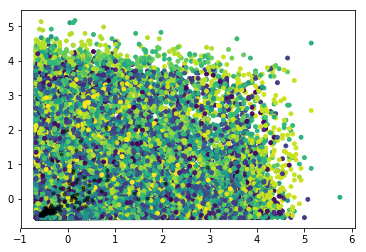

In [21]:
plt.scatter(total_descriptors[:, 0], total_descriptors[:, 1], c=y_kmeans, s=15, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=10, alpha=0.5);
plt.show()